In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 8.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=1c5c05ac591315bcaaec01554876667553967dae925a130c775453584cf49af8
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-mfu6qaxn
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-mfu6qaxn
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 1.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=512492c4196f748358ed4fdcdb64c0e5154b4086b871d7cb5f09df14d7c78c47
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import json
import os
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog  
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

1.5.0+cu101 False


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset')
# data paths
train_path = os.path.join(data_path, 'train') 
test_path = os.path.join(data_path, 'test')
val_path = os.path.join(data_path, 'validation')

# train_path = os.path.join(data_path, 'train_small') 
# test_path = os.path.join(data_path, 'test_small')
# val_path = os.path.join(data_path, 'validation_small')

# label files
with open(os.path.join(data_path, 'train.json')) as f:
    train_labels = json.load(f)
with open(os.path.join(data_path, 'test.json')) as f:
    test_labels = json.load(f)
with open(os.path.join(data_path, 'val.json')) as f:
    val_labels = json.load(f)

# with open(os.path.join(data_path, 'train_small.json')) as f:
#     train_labels = json.load(f)
# with open(os.path.join(data_path, 'test_small.json')) as f:
#     test_labels = json.load(f)
# with open(os.path.join(data_path, 'val_small.json')) as f:
#     val_labels = json.load(f)

In [0]:
# need to change image path and set bbox_mode to 
for ind, elem in enumerate(train_labels):
    train_labels[ind]['file_name'] = os.path.join(train_path, train_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(train_labels[ind]['annotations']):
        train_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS

for ind, elem in enumerate(test_labels):
    test_labels[ind]['file_name'] = os.path.join(test_path, test_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(test_labels[ind]['annotations']):
        test_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS
  
for ind, elem in enumerate(val_labels):
    val_labels[ind]['file_name'] = os.path.join(val_path, val_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(val_labels[ind]['annotations']):
        val_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS

In [7]:
val_labels[0] # detectron2 style labels

{'annotations': [{'bbox': [0.0, 0.5952, 1024.0, 768.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 24}],
 'file_name': '/content/gdrive/My Drive/Colab Notebooks/dataset/validation/007f71665b0812a7.jpg',
 'height': 768,
 'image_id': '007f71665b0812a7',
 'width': 1024}

In [0]:
# returns dataset
def get_data_dicts(d):
    if d == 'train':
        return train_labels
    elif d == 'val':
        return val_labels
    elif d == 'test':
        return test_labels

# register dataset
for d in ["train", "val", "test"]:
    DatasetCatalog.register("data_" + d, lambda d=d: get_data_dicts(d))

    # large dataset
    MetadataCatalog.get("data_" + d).set(thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch',
                                                        'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi',
                                                        'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow',
                                                        'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool',
                                                        'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack']).set(evaluator_type='coco')
    
    # small dataset
    #MetadataCatalog.get("data_" + d).set(thing_classes=['Bathtub', 'Coffeemaker', 'Gas Stove']).set(evaluator_type='coco')

data_metadata = MetadataCatalog.get("data_train")

In [9]:
data_metadata

Metadata(evaluator_type='coco', name='data_train', thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch', 'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi', 'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow', 'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool', 'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack'])

In [10]:
from detectron2.data.catalog import Metadata
a = Metadata(name = 'data_train', evaluator_type='coco', thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch', 'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi', 'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow', 'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool', 'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack'])
a

Metadata(evaluator_type='coco', name='data_train', thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch', 'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi', 'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow', 'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool', 'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack'])

In [11]:
img = cv2.imread(os.path.join(val_path, os.listdir(val_path)[3]))
visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(val_labels[3])
cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
val_labels[3] # detectron2 style labels

{'annotations': [{'bbox': [0.0, 413.9832160000001, 1024.0, 757.892364],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 23}],
 'file_name': '/content/gdrive/My Drive/Colab Notebooks/dataset/validation/019347cc4772963d.jpg',
 'height': 758,
 'image_id': '019347cc4772963d',
 'width': 1024}

**Predict from loaded model**

In [0]:
# load model from saved file and returns default predictor
def load_model(model_type):
    cfg = get_cfg()

    # add project-specific config
    cfg.merge_from_file(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks') + '/config_' + model_type + '.yaml')

    # change inference type to cpu to allow prediction to load
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # load_model from saved file
    cfg.DATASETS.TEST = ("data_test", )
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set threshold for this model
    cfg.MODEL.WEIGHTS = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output') + '/model_' + model_type + '_final.pth'

    return DefaultPredictor(cfg)

In [0]:
from detectron2.structures import Instances

# draw image and create prediction
def inference(img_path, predictor, model_type):
    im = cv2.imread(img_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], 
                   metadata = data_metadata,
                   scale = 0.5)
    
    # take only predictions with 25% confidence only for RetinaNet as they tend to overdraw
    if model_type in ['RN-50-3x', 'RN-101-3x']:
        filtered = outputs['instances'].to("cpu")._fields
        filtered_idx = []
        for i in range(len(filtered['scores'])):
            if filtered['scores'][i] >= 0.25:
                filtered_idx.append(i)

        a = Instances(image_size=(im.shape[0],im.shape[1]), pred_boxes = outputs['instances']._fields['pred_boxes'][filtered_idx], 
                      pred_classes = outputs['instances']._fields['pred_classes'][filtered_idx], 
                      scores = outputs['instances']._fields['scores'][filtered_idx])

        v = v.draw_instance_predictions(a.to("cpu"))
        cv2_imshow(v.get_image()[:, :, ::-1])
    
    # take all predictions for faster RCNN
    else:
      v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
      cv2_imshow(v.get_image()[:,:,::-1])

**MODEL 1: R50-FPN-3x**

In [0]:
predictor = load_model('R50-FPN-3x')

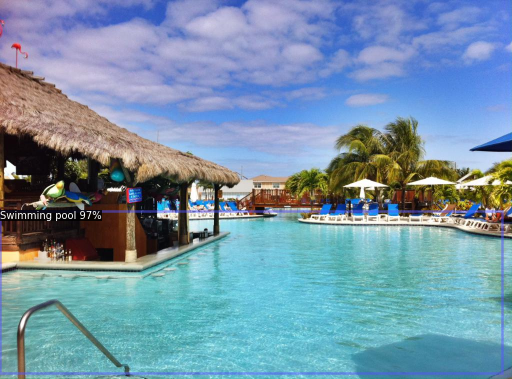

In [0]:
# one of the validation images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset', 'validation') + '/019347cc4772963d.jpg', predictor, 'R50-FPN-3x')

In [0]:
# predict custom images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'custom photos', 'IMG_9379.JPG'), predictor, 'R50-FPN-3x')

**MODEL 2: R101-FPN-3x**

In [0]:
predictor = load_model('R101-FPN-3x')

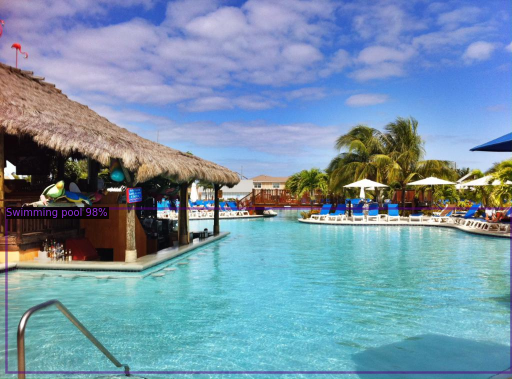

In [0]:
# one of the validation images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset', 'validation') + '/019347cc4772963d.jpg', predictor, 'R101-FPN-3x')

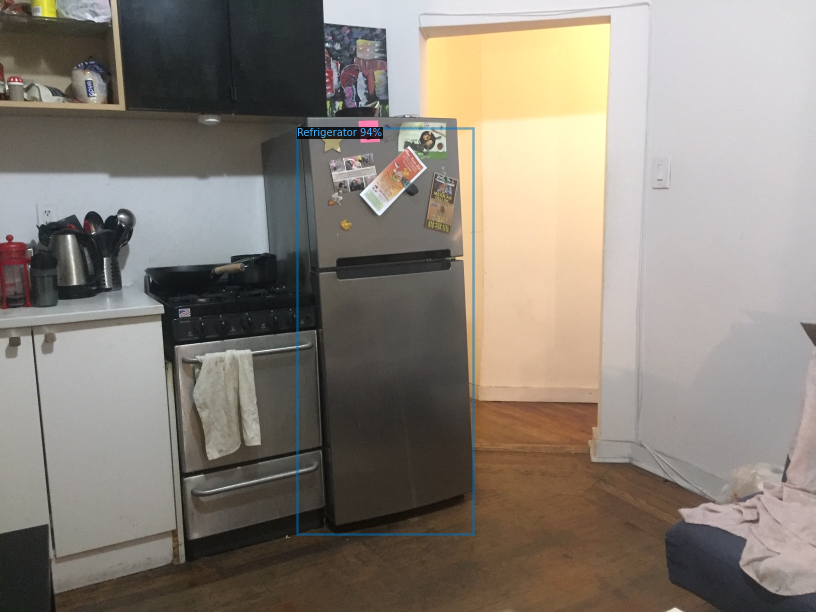

In [0]:
# predict custom images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'custom photos', 'IMG_9379.JPG'), predictor, 'R101-FPN-3x')

**MODEL3: RN-50-3x**

In [0]:
predictor = load_model('RN-50-3x')

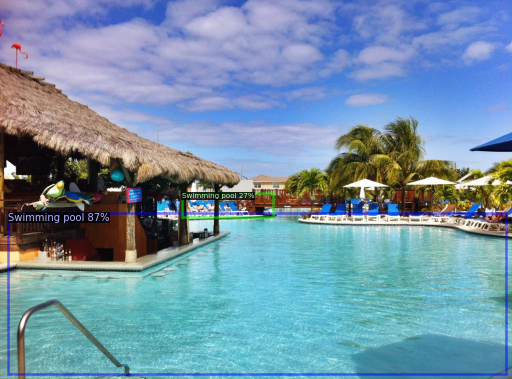

In [16]:
# one of the validation images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset', 'validation') + '/019347cc4772963d.jpg', predictor, 'RN-50-3x')

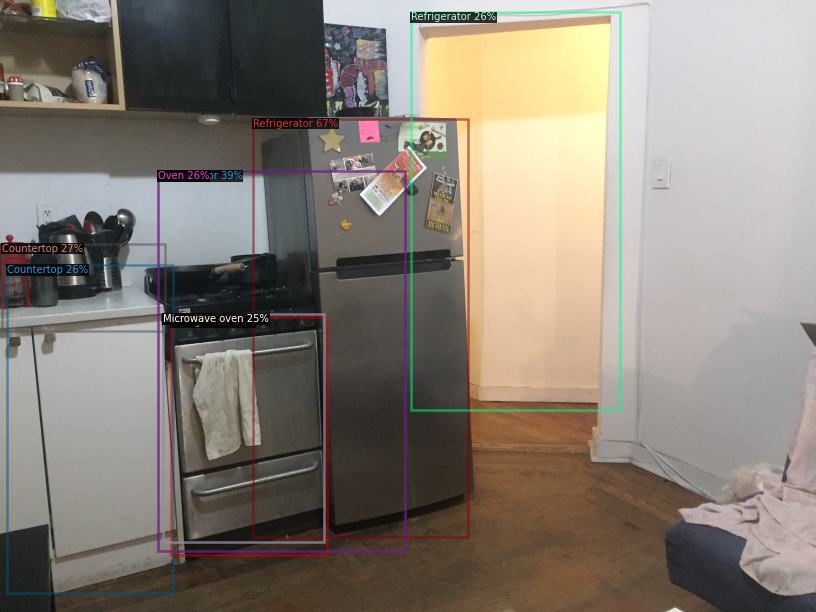

In [0]:
# predict custom images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'custom photos', 'IMG_9379.JPG'), predictor, 'RN-50-3x')

**MODEL4: RN-101-3x**

In [0]:
predictor = load_model('R101-FPN-3x')

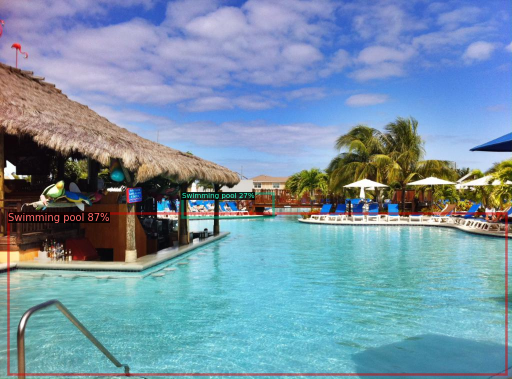

In [0]:
# one of the validation images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset', 'validation') + '/019347cc4772963d.jpg', predictor, 'RN-101-3x')

In [0]:
# predict custom images
inference(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'custom photos', 'IMG_9379.JPG'), predictor, 'RN-101-3x')

**Deployment**

In [0]:
!sudo apt-get install protobuf-compiler libprotoc-dev
!pip install onnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libprotoc-dev is already the newest version (3.0.0-9.1ubuntu1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [0]:
# BASE FILE: https://github.com/facebookresearch/detectron2/blob/master/tools/deploy/caffe2_converter.py

#import argparse
import os
import onnx
import torch

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
from detectron2.export import Caffe2Tracer, add_export_config
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger


def setup_cfg(model_type):
    # cuda context is initialized before creating dataloader, so we don't fork anymore
    cfg = get_cfg()
    cfg.DATALOADER.NUM_WORKERS = 0
    cfg = add_export_config(cfg)  # Convert to caffe2 config file

    # add project-specific config
    cfg.merge_from_file(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks') + '/config_' + model_type + '.yaml')

    # load_model from saved file
    cfg.DATASETS.TEST = ("data_test", )
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set threshold for this model
    cfg.MODEL.WEIGHTS = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output') + '/model_' + model_type + '_final.pth'
    
    # POTENTIAL ERROR for deployment  -> Change cfg.MODEL.DEVICE = "cpu"


    # original code
    cfg.freeze()
    if cfg.MODEL.DEVICE != "cpu":
        TORCH_VERSION = tuple(int(x) for x in torch.__version__.split(".")[:2])
        assert TORCH_VERSION >= (1, 5), "PyTorch>=1.5 required for GPU conversion!"
    return cfg


def main(model_type):
    logger = setup_logger()
    outputdir = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'deployed')
    os.makedirs(outputdir, exist_ok=True)

    cfg = setup_cfg(model_type)

    # create a torch model
    torch_model = build_model(cfg)
    DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)

    # get a sample data
    data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
    first_batch = next(iter(data_loader))

    # convert and save caffe2 model
    tracer = Caffe2Tracer(cfg, torch_model, first_batch)
    #if args.format == "caffe2":
    caffe2_model = tracer.export_caffe2()
    caffe2_model.save_protobuf(outputdir)
    # draw the caffe2 graph
    caffe2_model.save_graph(os.path.join(outputdir, "model.svg"), inputs=first_batch)

    # run evaluation with the converted model
    dataset = cfg.DATASETS.TEST[0]
    data_loader = build_detection_test_loader(cfg, dataset)
    # NOTE: hard-coded evaluator. change to the evaluator for your dataset
    evaluator = COCOEvaluator(dataset, cfg, True, outputdir)
    metrics = inference_on_dataset(caffe2_model, data_loader, evaluator)
    print_csv_format(metrics)

In [0]:
main('RN-50-3x')

[05/25 02:31:02 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    Bathtub    | 59           |      Bed      | 328          | Billiard ta.. | 85           |
|  Ceiling fan  | 40           |  Coffeemaker  | 50           |     Couch     | 104          |
|  Countertop   | 143          |  Dishwasher   | 3            |   Fireplace   | 62           |
|   Fountain    | 63           |   Gas stove   | 49           |    Jacuzzi    | 28           |
| Kitchen & d.. | 157          | Microwave o.. | 46           |    Mirror     | 84           |
|     Oven      | 53           |    Pillow     | 264          |     Porch     | 100          |
| Refrigerator  | 82           |    Shower     | 32           |     Sink      | 119          |
|   Sofa bed    | 150          |    Stairs     | 122          

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:209: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:209: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))


[05/25 02:31:12 d2.export.caffe2_export]: ONNX export Done. Exported predict_net (before optimizations):
| type          | input                                                                                               | output        |
|:--------------|:----------------------------------------------------------------------------------------------------|:--------------|
| AliasWithName | ['data']                                                                                            | ['310']       |
| AliasWithName | ['im_info']                                                                                         | ['311']       |
| Cast          | ['310']                                                                                             | ['312']       |
| Sub           | ['312', '_wrapped_model.pixel_mean']                                                                | ['313']       |
| Div           | ['313', '_wrapped_model.pixel_std']                          